# Pre-trained Vectors - Sentence -  Toxic Comments

A corpus of manually labeled comments - classifying each comment by its type of toxicity is available on Kaggle. We will aim to do a binary classification of whether a comment is toxic or not

This notebook uses **Pre-trained Sentence Embedding** from Spacy to do the task.

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

Using TensorFlow backend.


### Get the Data

Uncomment these shell lines to get the data

In [2]:
#!wget http://bit.do/deep_toxic_train -P data/
#!mv data/deep_toxic_train data/train.zip

In [3]:
df = pd.read_csv("data/train.zip")

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Import the required libraries

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Create the Input & Output Data

In [6]:
train_sentences = df["comment_text"]
train_sentences.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

**Pre-processing the train data**
- Tokenization: "This is an apple" -> ["This", "is", "an", "apple"]
- Indexing: {0: "This", 1: "is", 2: "an", 3: "apple"}
- Index Representation: [0, 1, 2, 3]

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
# Tokenizer
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_sentences))

In [9]:
# Index Representation
tokenized_train = tokenizer.texts_to_sequences(train_sentences)

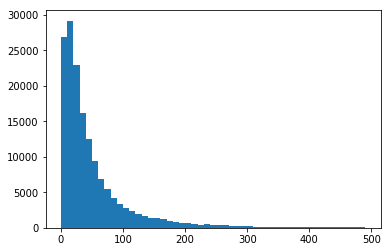

In [10]:
# Selecting Padding
# find length of each sentence and plot the length
number_of_words = [len(comment) for comment in tokenized_train]
plt.hist(number_of_words, bins = np.arange(0, 500, 10));

In [11]:
# Padding to make it uniform
maxlen = 200
X = pad_sequences(tokenized_train, maxlen = maxlen)

In [12]:
labels = df.iloc[:,2].values

In [13]:
# Baseline Benchmark 
1 - df.iloc[:,2].sum()/df.iloc[:,2].count()

0.90415551697990237

In [14]:
from keras.utils import to_categorical
y = to_categorical(labels)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127656, 200), (31915, 200), (127656, 2), (31915, 2))

### Step 1a: Creating pre-trained Embedding

In [17]:
import spacy

In [20]:
#!python -m spacy download en_core_web_md

In [21]:
nlp = spacy.load('en_core_web_md')

In [22]:
doc = nlp("This is some text that I am processing with Spacy")

**word vector**

In [30]:
doc[3].vector.shape

(300,)

**Sentence vector**

Spacy also provides an option of sentence vectors

In [37]:
doc.vector.shape

(300,)

In [25]:
df2 = df.copy()

In [26]:
df2.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [27]:
def word_embedding(text):
    doc = nlp(text)
    return doc.vector

In [ ]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="progress")

In [28]:
# this didn't run in reasonable time
# df2["word_embedding"] = df2["comment_text"].apply(word_embedding)

In [29]:
%%time
embedding_matrix = df2.iloc[:1000,1].apply(word_embedding)

CPU times: user 1min 7s, sys: 7.33 s, total: 1min 14s
Wall time: 2min 35s


In [31]:
embedding_matrix[0:2]

0    [0.0147541, 0.0950991, -0.182347, -0.0324759, ...
1    [-0.0541294, 0.254045, -0.045151, -0.0559909, ...
Name: comment_text, dtype: object

In [32]:
# reshaping the embedding matrix
emb_mat = np.empty([1000, 300])
j = 0
for i in embedding_matrix:
    emb_mat[j] = i
    j += 1

In [33]:
emb_mat.shape

(1000, 300)

### Step 2: Create the Model Architecture

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten

In [36]:
model = Sequential()
model.add(Embedding(1000, 300, input_length=maxlen, t))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          300000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920032   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 2,220,098
Trainable params: 2,220,098
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.layers[0].set_weights([emb_mat])
model.layers[0].trainable = False

### Step 3: Compile the Model & Fit on the Data

In [38]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
output = model.fit(X_train[:1000], y_train, batch_size=128, epochs=5, validation_split=0.2)

In [109]:
history = model.fit(X_train[:1000], y_train[:1000],
                    epochs=2,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 1000 samples, validate on 31915 samples
Epoch 1/2
1000/1000 [==============================] - 2s 2ms/step - loss: 1.3040 - acc: 0.8470 - val_loss: 1.4149 - val_acc: 0.9042
Epoch 2/2
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2335 - acc: 0.8635 - val_loss: 1.4839 - val_acc: 0.9042


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
output = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

### Step 4: Evaluate the Model

In [ ]:
vis.metrics(output.history)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Step 5: Visualise evaluation & Make a prediction

In [ ]:
predict_classes = model.predict_classes(X_test)

In [ ]:
pd.crosstab(y_test, predict_classes)

In [102]:
doc = nlp("temperature is quite hot")